# Infinite Gaussian Mixture Model

The paper presents a Markov Chain Monte Carlo method for inference based on an Infinite Gaussian Mixture Model. The data is assumed to have been generated from a countably infinite Mixture of Gaussians. The MCMC method gives us the parameters of the Gaussian components that generated the data. One might wonder how the method can possibly tell us infinitely many parameters. This is not a concern because at any time, we'll see only finite amount of data. The method will give us only the relevant parameters.

This method is applicable when one wants to cluster data without knowing the number of clusters in advance. In this implementation, the observations will be one-dimensional.

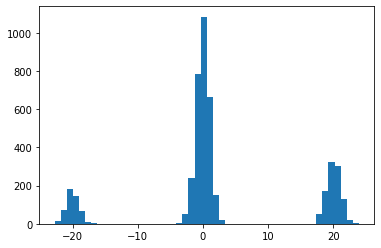

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from sampler import *
import pprint

# Generate test data.
y = np.concatenate([np.random.normal(-20, 1, 500),
                    np.random.normal(0, 1, 3000),
                    np.random.normal(20, 1, 1000)]).reshape(-1, 1)
mu_y = np.mean(y)
var_y = np.var(y)

c = np.array([0]*500 + [1]*3000 + [2]*1000)
n = len(c)
plt.hist(y, bins=50)
plt.show()

k = 3

Let's assume that $k$, the number of mixture components was known. The model parameters would be $k$ means and $k$ precisions for the Gaussians, and the mixture weights. 

Means are denoted by $\mu_1, \cdots, \mu_k$. Precisions by $s_1, \cdots, s_k$. Finally, the mixture weights are denoted by $\pi_1, \cdots, \pi_k$.

\begin{equation}
p(y | \mu_1, \cdots, \mu_k, s_1, \cdots, s_k, \pi_1, \cdots, \pi_k) = \sum_{i = 1}^k \pi_i \mathcal{N}(\mu_i, \frac{1}{s_i})
\end{equation} 

The model parameters have hyperparameters associated with them. Parameters $\mu_i$ are controlled by two hyperparameters $\lambda$ and $r$. Parameters $s_i$ are controlled by $\beta$ and $\omega$. The mixture weights are controlled by a single hyperparameter $\alpha$. 

The Bayes Net, with the priors on the hyperparameters is given below.

In [2]:
k = 3

'''with pm.Model() as finiteGMMmodel:
    # TODO: Distribution parameters may be wrong here.
    lambda_ = pm.Normal('lambda', mu=mu_y, tau=1/var_y)
    r_ = pm.Gamma('r', mu=1, sigma=1/var_y)
    mu_ = pm.Normal('mu', mu=lambda_, tau=r_, shape=k)
    beta_ = pm.InverseGamma('beta', mu=1, sigma=1)
    omega_ = pm.Gamma('omega', alpha=1, beta=var_y)
    s_ = pm.Gamma('s', mu=beta_, sigma=1/omega_, shape=k)
    alpha_ = pm.Gamma('alpha', alpha=1, beta=1)
    pi_ = pm.Dirichlet('pi', a=np.ones(k) * (alpha_ / k))
    c_ = pm.Categorical('c', p=pi_)
    y_ = pm.Normal('y', mu=mu_[c_], tau=s_[c_], observed=y)

pm.model_to_graphviz(finiteGMMmodel)'''

"with pm.Model() as finiteGMMmodel:\n    # TODO: Distribution parameters may be wrong here.\n    lambda_ = pm.Normal('lambda', mu=mu_y, tau=1/var_y)\n    r_ = pm.Gamma('r', mu=1, sigma=1/var_y)\n    mu_ = pm.Normal('mu', mu=lambda_, tau=r_, shape=k)\n    beta_ = pm.InverseGamma('beta', mu=1, sigma=1)\n    omega_ = pm.Gamma('omega', alpha=1, beta=var_y)\n    s_ = pm.Gamma('s', mu=beta_, sigma=1/omega_, shape=k)\n    alpha_ = pm.Gamma('alpha', alpha=1, beta=1)\n    pi_ = pm.Dirichlet('pi', a=np.ones(k) * (alpha_ / k))\n    c_ = pm.Categorical('c', p=pi_)\n    y_ = pm.Normal('y', mu=mu_[c_], tau=s_[c_], observed=y)\n\npm.model_to_graphviz(finiteGMMmodel)"

Having observed data, the parameters and the hyperparameters can be inferred by Gibbs Sampling.

In the Gibbs Sampling update, the (hyper)parameters are listed in a sequence and each (hyper)parameter is updated by sampling from its distribution conditioned on all the other (hyper)parameters. Repeated application of this update ensures that in the limit, the values of the (hyper)parameters obtained arise from the joint distribution:

\begin{equation}
\mathbf{Pr}(\vec{\mu}, \vec{s}, \vec{\pi}, c_1, \cdots, c_n, \lambda, r, \beta, \omega, \alpha |y_1, \cdots, y_n)
\end{equation}

To cover my bases, I'll assume that the $c_i$'s are known. I'll use the Gibbs Sampling updates to infer model parameters from the following distribution.

\begin{equation}
\mathbf{Pr}(\vec{\mu}, \vec{s}, \vec{\pi}, \lambda, r, \beta, \omega, \alpha |c_1, \cdots, c_n, y_1, \cdots, y_n)
\end{equation}

The conditional for the means are:

\begin{equation}
\mathbf{Pr}(\mu_j | \vec{c}, \vec{y}, s_j, \lambda, r) \sim \mathcal{N}(\frac{\bar{y_j}n_js_j + \lambda r}{n_js_j+r}, \frac{1}{n_js_j + r})
\end{equation}

Where, $\bar{y_j}$ is sum of all those y's in class $j$. We compute the conditional for the means of all classes simultaneously over here. Note that only variables upon which $\mu_j$ is conditioned on contain it's Markov Blanket.

In [3]:
def meanSampler (c, y, s, lambda_, r, k, **kwargs) :
    n = np.array([np.sum(c == j) for j in range(k)])
    y_ = np.array([np.sum(y[c == j]) / nj for j, nj in enumerate(n)])
    mean = (y_ * n * s + lambda_ * r) / (n * s + r)
    var = 1 / (n * s + r)
    sample = rng.randn(k)
    return mean + np.sqrt(var) * sample

The conditional for the precisions are: 

\begin{equation}
\mathbf{Pr}(s_j | \vec{c}, \vec{y}, \mu_j, \beta, \omega) \sim \mathcal{G}(\beta + n_j, \Big(\frac{1}{\beta + n_j}(\omega\beta + \sum_{i:c_i=j}(y_i - \mu_j)^2)\Big)^{-1})
\end{equation}


In [4]:
def precisionSampler (c, y, mu, beta, omega, k, **kwargs) :
    n = np.array([np.sum(c == j) for j in range(k)])
    deltas = np.array([np.sum(np.linalg.norm(y[c == j] - mu_j)**2) for j, mu_j in enumerate(mu)])
    shape = beta + n
    mean = ((deltas + omega * beta) / shape) ** (-1)
    scale = mean / shape
    return rng.gamma(shape, scale)

Conditional for $\lambda$:

\begin{equation}
\mathbf{Pr}(\lambda | \vec{\mu}, r) \sim \mathcal{N}(\frac{\mu_y\sigma_y^{-2}+r\sum_{j=1}^k\mu_j}{\sigma_y^{-2}+kr}, \frac{1}{\sigma_y^{-2}+kr})
\end{equation}

Conditional for $r$:

\begin{equation}
\mathbf{Pr}(r | \vec{\mu}, \lambda) \sim \mathcal{G}(k+1, \Big(\frac{1}{k+1}(\sigma_y^2 + \sum_{j=1}^k(\mu_j - \lambda)^2)\Big)^{-1})
\end{equation}

In [5]:
def lambdaSampler(mu, mu_y, var_y, k, r, **kwargs) :
    mean = (mu_y*1/var_y + r*sum(mu))/(1/var_y + k*r)
    var = 1/(1/var_y + k*r)
    return mean + np.sqrt(var) * rng.randn()

def rSampler (mu, mu_y, var_y, k, lambda_, **kwargs) :
    shape = k + 1
    mean = ((1/shape)*(var_y + np.linalg.norm(mu - lambda_)**2))**-1
    scale = mean / shape
    return rng.gamma(shape, scale)

Conditional for $\beta$:

\begin{equation}
\mathbf{Pr}(\beta | \vec{s}, \omega) \propto \Gamma(\frac{\beta}{2})^{-k}exp(\frac{-1}{2\beta})(\frac{\beta}{2})^{(k\beta-3)/2}\prod_{j=1}^k(s_j\omega)^{\beta/2}exp(-\frac{\beta s_j \omega}{2})
\end{equation}

We'll use Adaptive Rejection Sampling to sample from $\beta$'s. I'm confused because if we need just one sample, what is the point of using ARS. I need to check whether ARS works when given an unnormalized distribution. Maybe it is hard to get good proposals in general.

Conditional for $\omega$:

\begin{equation}
\mathbf{Pr}(\omega | \vec{s}, \beta) \sim \mathcal{G}(k\beta+1, \Big(\frac{1}{k\beta+1}(\sigma_y^2 + \beta\sum_{j=1}^ks_j)\Big)^{-1})
\end{equation}

In [6]:
def betaSampler (s, omega, k, **kwargs) :
    def logU (y) :
        beta = torch.exp(y)
        t1 = (-k * torch.lgamma(beta/2))
        t2 = (-1/(2*beta))
        t3 = ((k*beta-3)/2)*(y - math.log(2))
        t4 = (beta/2)*np.sum(np.log(s*omega) - s*omega)
        return y + t1 + t2 + t3 + t4
    sample = adaptiveRejectionSampling(logU, 1, (-math.inf, math.inf))
    return np.exp(sample)

def omegaSampler (s, var_y, k, beta, **kwargs) :
    shape = k*beta + 1
    mean = ((1/shape)*(var_y + beta * sum(s)))**-1
    scale = mean / shape
    return rng.gamma(shape, scale)

Having defined all the conditionals, we can do inference using Gibbs Sampling

In [7]:
parameters = {
    'mu': np.zeros(3),
    's': np.ones(3),
    'lambda_': mu_y,
    'r': 1, 
    'beta': var_y,
    'omega': var_y
}

samplers = {
    'mu': meanSampler,
    's': precisionSampler,
    'lambda_': lambdaSampler,
    'r': rSampler, 
    'beta': betaSampler,
    'omega': omegaSampler
}

others = {
    'k': 3,
    'mu_y': mu_y,
    'var_y': var_y,
    'c': c,
    'y': y
}

inferredParameters = gibbs(parameters, samplers, 10, **others)
pprint.PrettyPrinter(indent=2).pprint(inferredParameters)

100%|██████████| 10/10 [00:00<00:00, 57.29it/s]

{ 'beta': array([0.31796712], dtype=float32),
  'lambda_': 0.9678000046422276,
  'mu': array([-1.99958841e+01, -1.18963417e-02,  2.00424531e+01]),
  'omega': array([0.03029385]),
  'r': 0.004568612495703457,
  's': array([0.98041001, 1.0132418 , 0.92838544])}


This task was easy. Since we knew the components, the problem became analogous to fitting three independent gaussians instead of a mixture. Also, the data, once seperated on the basis of class, gave good indication of the mean and the variance for the mixture components.

Now, let's suppose that the $c_i$'s are not known. Firstly, we integrate over all $\vec{\pi}$ so that parent of the $c_i$'s is $\alpha$. Then, the conditional for $\alpha$ is given by:

\begin{equation}
\mathbf{Pr}(\alpha | \vec{c}) \propto \frac{\alpha^{k - 3/2}exp(\frac{-1}{2\alpha})\Gamma(\alpha)}{\Gamma(n + \alpha)}
\end{equation}

We'll use Adaptive Rejection Sampling to obtain samples of $\alpha$.

In [8]:
def alphaSampler (c, k, **kwargs) : 
    n = len(c)
    def logU (y) : 
        alpha = torch.exp(y)
        t1 = y * (k - (3/2))
        t2 = -1/(2 * alpha)
        t3 = torch.lgamma(alpha)
        t4 = -torch.lgamma(n + alpha)
        return y + t1 + t2 + t3 + t4
    sample = adaptiveRejectionSampling(logU, 1, (-math.inf, math.inf))
    return np.exp(sample)

The Markov Blanket of $c_i$ contains $y_i$, $\vec{\mu}$, $\vec{s}$ and $\alpha$. Hence, we have to find an expression for:

\begin{equation}
\mathbf{Pr}(c_i | y_i, \vec{\mu}, \vec{s}, \alpha) 
\end{equation}

Each $c_i$ is conditionally independent of the $\vec{c}_{-i}$. Hence, if we condition on this variable as well, it doesn't matter.

\begin{equation}
\mathbf{Pr}(c_i | y_i, \vec{\mu}, \vec{s}, \alpha) = \mathbf{Pr}(c_i | y_i, \vec{\mu}, \vec{s}, \alpha, \vec{c}_{-i}) 
\end{equation}

Now, it is much simpler to factor the conditional probability distribution.

\begin{equation}
\mathbf{Pr}(c_i | y_i, \vec{\mu}, \vec{s}, \alpha, \vec{c}_{-i}) \propto \mathbf{Pr}(y_i | \vec{c}, \vec{\mu}, \vec{s}, \alpha) \times \mathbf{Pr}(c_i | \vec{c}_{-i}, \vec{\mu}, \vec{s}, \alpha)
\end{equation}

The first term is simply a Gaussian centered at $\mu_{c_i}$ with precision $s_{c_i}$. Since, $c_i$ is conditionally independent of all non-descendants given it's parent $\alpha$, the second term is becomes $\mathbf{Pr}(c_i | \vec{c}_{-i}, \alpha)$. This has a closed form solution obtained by solving the Dirichlet Integral to integrate out $\vec{\pi}$. 

\begin{equation}
\mathbf{Pr}(c_i | \vec{c}_{-i}, \alpha) = \frac{n_{-i, j} + \frac{\alpha}{k}}{n - 1 + \alpha}
\end{equation}

Here, $n_{-i, j}$ is the number of $j$ components when data point $i$ is not included.

Although according to Gibbs Sampling, we have to update the $c_i$'s sequentially, I'll update them in parallel because I don't think it makes that big a difference.

In [9]:
def cSampler (c, y, mu, s, alpha, k, **kwargs) :
    n = len(c)
    nj = np.array([np.sum(c == j) for j in range(k)])
    nij = k
    delta = (np.repeat(y, k, axis=1) - mu) ** 2
    probs = ((nij + (alpha / k)) / (n - 1 + alpha)) * (s**(1/2) * np.exp(-s * delta/ 2))
    probs = probs / np.sum(probs, axis=1, keepdims=True)
    return np.array([np.argmax(rng.multinomial(1, pvals=pvals)) for pvals in probs])    

In [10]:
parameters = {
    'alpha': 1,
    'mu': np.zeros(3),
    's': np.ones(3),
    'lambda_': mu_y,
    'r': 1, 
    'beta': var_y,
    'omega': var_y,
    'c': np.array([np.random.randint(0, k) for _ in range(n)])
}

samplers = {
    'alpha': alphaSampler,
    'c': cSampler,
    'mu': meanSampler,
    's': precisionSampler,
    'lambda_': lambdaSampler,
    'r': rSampler, 
    'beta': betaSampler,
    'omega': omegaSampler
}

others = {
    'k': 3,
    'mu_y': mu_y,
    'var_y': var_y,
    'y': y
}

inferredParameters = gibbs(parameters, samplers, 200, **others)
pprint.PrettyPrinter(indent=2).pprint(inferredParameters)

100%|██████████| 200/200 [00:30<00:00,  6.57it/s]

{ 'alpha': array([0.18565221], dtype=float32),
  'beta': array([0.423374], dtype=float32),
  'c': array([2, 2, 2, ..., 1, 1, 1]),
  'lambda_': -0.06477585202582059,
  'mu': array([  0.03802339,  20.02062615, -14.51761252]),
  'omega': array([0.01215156]),
  'r': 0.0008575192960488669,
  's': array([1.21340523, 0.94654014, 0.01166924])}


We got the means and the precisions right! Now, we need to take it to the infinite limit. The extension is quite straightforward to implement but a bit difficult to derive. 

In the beginning, none of the data points $y_i$ will have a component associated with them. They will be associated with a pseudo-component corresponding to all the unrepresented components. 

During the sampling of the indicator variables, for each $y_i$, it'll be decided whether the corresponding component is one of the finite components made so far or whether the component is one of the infinite unrepresented components. If an unrepresented component is chosen for the $y_i$, then a new class label is added and the mean and precision for this new class label is added. 

At any point, if there is a component which has no $y_i$ associated with it, then that component, along with it's parameters is discarded.

In this manner, the algorithm adaptively chooses $k$, the correct number of components.

In [11]:
k = 0

def unrepresentedMeanSampler (lambda_, r, **kwargs) : 
    var = 1 / r
    return lambda_ + np.sqrt(var) * rng.randn()

def unrepresentedPrecisionSampler (beta, omega, **kwargs) :
    shape = beta
    mean = 1 / omega
    scale = mean / shape
    return rng.gamma(shape, scale)

def cSampler (c, y, mu, s, unrepresentedMu, unrepresentedPrecision, alpha, lambda_, r, beta, omega, **kwargs):
    global k
    s_, mu_ = np.array(s), np.array(mu)
    n = len(c)
    nij = (n - np.array([c == j for j in range(k)])).T
    delta1 = (np.repeat(y, k, axis=1) - mu) ** 2
    delta2 = (y - unrepresentedMu) ** 2  
    #print(delta1, delta2)
    probs1 = (nij / (n - 1 + alpha)) * (np.sqrt(s_/(2*np.pi)) * np.exp(-s_ * delta1 / 2))
    likelihood = np.sqrt(unrepresentedPrecision) * np.exp(-unrepresentedPrecision * delta2 / 2) 
    probs2 = (alpha / (n - 1 + alpha)) * likelihood
    # Probabilities of the existing components concatenated with probability
    # for all the other components put together.
    probs = np.concatenate((probs1, probs2), axis=1)
    probs = probs / np.sum(probs, axis=1, keepdims=True)
    # New Components sampled using those probabilities
    newC = np.array([np.argmax(rng.multinomial(1, pvals=pvals)) for pvals in probs])
    new_nj = np.array([np.sum(c == j) for j in range(k)])
    # Time to remove all those components who have no 
    # data point associated with them anymore!
    notClassLabels = np.array(range(k))[new_nj == 0]
    for label in notClassLabels : 
        newC[newC == label] = -1
    # Re-index the remaining component labels.
    classLabels = np.array(range(k))[new_nj > 0]
    mu.clear()
    mu.extend(mu_[new_nj > 0].tolist())
    s.clear()
    s.extend(s_[new_nj > 0].tolist())
    newK = sum(new_nj > 0)
    for i, label in enumerate(classLabels) :
        newC[newC == label] = i
    # If any data point is assigned one of the 
    # unrepresented classes, initialize a new class
    # with parameters mean and precision. 
    if sum(newC == k) > 0 : 
        newC[newC == k] = newK
        mu.append(unrepresentedMu)
        s.append(unrepresentedPrecision)
        k = newK + 1
    return newC

In [12]:
######################################################
## Redefining the previous samplers so that they can
## work with varying number of components.
######################################################

def meanSampler (c, y, s, lambda_, r, **kwargs) :
    n = np.array([np.sum(c == j) for j in range(k)])
    y_ = np.array([np.sum(y[c == j]) / nj for j, nj in enumerate(n)])
    mean = (y_ * n * s + lambda_ * r) / (n * s + r)
    var = 1 / (n * s + r)
    sample = rng.randn(k)
    return (mean + np.sqrt(var) * sample).tolist()

def precisionSampler (c, y, mu, beta, omega, **kwargs) :
    n = np.array([np.sum(c == j) for j in range(k)])
    deltas = np.array([np.sum(np.linalg.norm(y[c == j] - mu_j)**2) for j, mu_j in enumerate(mu)])
    shape = beta + n
    mean = ((deltas + omega * beta) / shape) ** (-1)
    scale = mean / shape
    return rng.gamma(shape, scale).tolist()

def lambdaSampler(mu, mu_y, var_y, r, **kwargs) :
    mean = (mu_y*1/var_y + r*sum(mu))/(1/var_y + k*r)
    var = 1/(1/var_y + k*r)
    return mean + np.sqrt(var) * rng.randn()

def rSampler (mu, mu_y, var_y, lambda_, **kwargs) :
    shape = k + 1
    mean = ((1/shape)*(var_y + np.linalg.norm(np.array(mu) - lambda_)**2))**-1
    scale = mean / shape
    return rng.gamma(shape, scale)

def betaSampler (s, omega, **kwargs) :
    s_ = np.array(s)
    def logU (y) :
        if k == 0 : 
            return y + (-3/2) * (y - math.log(2)) - (1/2) * torch.exp(-y)
        beta = torch.exp(y)
        t1 = (-k * torch.lgamma(beta/2))
        t2 = (-1/(2*beta))
        t3 = ((k*beta-3)/2)*(y - math.log(2))
        t4 = (beta/2)*np.sum(np.log(s_*omega) - s_*omega)
        return y + t1 + t2 + t3 + t4
    sample = adaptiveRejectionSampling(logU, 1, (-math.inf, math.inf)).pop()
    return np.exp(float(sample))

def omegaSampler (s, var_y, beta, **kwargs) :
    shape = k*beta + 1
    mean = ((1/shape)*(var_y + beta * sum(s)))**-1
    scale = mean / shape
    return rng.gamma(shape, scale)

def alphaSampler (c, **kwargs) :
    n = len(c)
    def logU (y) :
        alpha = torch.exp(y)
        t1 = y * (k - (3/2))
        t2 = -1/(2 * alpha)
        t3 = torch.lgamma(alpha)
        t4 = -torch.lgamma(n + alpha)
        return y + t1 + t2 + t3 + t4
    sample = adaptiveRejectionSampling(logU, 1, (-math.inf, math.inf)).pop()
    return np.exp(float(sample))

In [13]:
parameters = {
    'alpha': 1,
    'mu': [],
    's': [],
    'lambda_': mu_y,
    'r': 1, 
    'beta': var_y,
    'omega': var_y,
    'c': np.ones(n) * -1,
    'unrepresentedMu': 0,
    'unrepresentedPrecision': 1
}

samplers = {
    'alpha': alphaSampler,
    'c': cSampler,
    'mu': meanSampler,
    's': precisionSampler,
    'lambda_': lambdaSampler,
    'r': rSampler, 
    'beta': betaSampler,
    'omega': omegaSampler,
    'unrepresentedMu': unrepresentedMeanSampler,
    'unrepresentedPrecision': unrepresentedPrecisionSampler
}

others = {
    'mu_y': mu_y,
    'var_y': var_y,
    'y': y
}

inferredParameters = gibbs(parameters, samplers, 1, **others)
pprint.PrettyPrinter(indent=2).pprint(inferredParameters)


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

{ 'alpha': 0.2026171387747238,
  'beta': 0.2203269933359313,
  'c': array([0, 0, 0, ..., 0, 0, 0]),
  'lambda_': -6.9706923880237515,
  'mu': [0],
  'omega': 0.002998988136705314,
  'r': 0.018696438924689536,
  's': [1],
  'unrepresentedMu': -14.21119506636325,
  'unrepresentedPrecision': 868.9177683900873}


As you can see, the number of classes are too many. But the mean and precisions are still accurate. Hence, if we were to sample from the model given by the inferred parameters, the samples will resemble those from the actual distribution!

In [14]:
k = 0


def nCRP(alpha, nCustomers):
    # Initialize top-level restaurant
    top_restaurant = [0]
    top_restaurant_tables = [[0]]

    # Initialize bottom-level restaurants
    bottom_restaurants = [[0]]

    # Assign customers to top-level restaurant
    top_assignments = [0]

    for i in range(1, nCustomers):
        # Probability of joining existing tables in the top-level restaurant
        top_probs = [len(table) / (i + alpha) for table in top_restaurant_tables]

        # Probability of starting a new table in the top-level restaurant
        top_probs.append(alpha / (i + alpha))

        # Sample table assignment in the top-level restaurant
        top_table = np.random.choice(len(top_restaurant_tables) + 1, p=top_probs)

        if top_table == len(top_restaurant_tables):
            # Start a new table in the top-level restaurant
            top_restaurant_tables.append([i])
        else:
            # Assign to an existing table in the top-level restaurant
            top_restaurant_tables[top_table].append(i)

        # Assign the customer to the chosen top-level restaurant table
        top_assignments.append(top_table)

        # Sample table assignment in the bottom-level restaurant
        bottom_restaurant = top_assignments[i]

        if bottom_restaurant == len(bottom_restaurants):
            # Start a new bottom-level restaurant
            bottom_restaurants.append([i])
        else:
            # Assign to an existing bottom-level restaurant
            bottom_restaurants[bottom_restaurant].append(i)

    return top_assignments, top_restaurant_tables, bottom_restaurants


In [15]:
def meanSampler(c, y, s, bottom_restaurants, **kwargs):
    k = len(s)
    mu = []
    for j in range(k):
        mu_j = np.mean(y[c == j]) if np.sum(c == j) > 0 else 0
        bottom_mu_j = [mu_i for mu_i, r_i in bottom_restaurants if r_i == j]
        if len(bottom_mu_j) > 0:
            mu_j += np.mean(bottom_mu_j)
        mu.append(mu_j)
    return mu

def precisionSampler(c, y, mu, bottom_restaurants, **kwargs):
    k = len(mu)
    s = []
    for j in range(k):
        s_j = np.var(y[c == j]) if np.sum(c == j) > 0 else 1
        bottom_s_j = [s_i for s_i, r_i in bottom_restaurants if r_i == j]
        if len(bottom_s_j) > 0:
            s_j += np.var(bottom_s_j)
        s.append(s_j)
    return s

def unrepresentedMeanSampler (lambda_, r, **kwargs) : 
    var = 1 / r
    return lambda_ + np.sqrt(var) * rng.randn()

def unrepresentedPrecisionSampler(beta, omega, **kwargs):
    shape = beta
    mean = 1 / omega
    scale = mean / shape
    return rng.gamma(shape, scale)



In [16]:
def lambdaSampler(mu, mu_y, var_y, r, **kwargs):
    k = len(mu)
    #nj = np.array([np.sum(c == j) for j in range(k)])  # Assuming 'c' is the cluster assignment variable
    mean = (mu_y * (1/var_y) + r * np.sum(mu)) / (var_y + k * r)
    var = 1 / (1/var_y + k * r)
    return mean + np.sqrt(var) * rng.randn()

def rSampler(mu, mu_y, var_y, lambda_, **kwargs):
    k = len(mu)
    shape = k + 1
    mean = ((1 / shape) * (var_y + np.sum((mu - lambda_) ** 2))) ** -1
    scale = mean / shape
    return rng.gamma(shape, scale)

def betaSampler(s, omega, bottom_restaurants, **kwargs):
    k = len(s)
    beta = 1
    for j in range(k):
        s_j = s[j]
        bottom_s_j = [s_i for s_i, r_i in bottom_restaurants if r_i == j]
        if len(bottom_s_j) > 0:
            s_j += np.sum(bottom_s_j)
        beta += np.sum(s_j)
    return beta

def omegaSampler(s, var_y, beta, bottom_restaurants, **kwargs):
    k = len(s)
    shape = k * beta + 1
    # mean = ((1 / shape) * (var_y + beta * np.sum(s))) ** -1
    mean = ((1 / shape) * (var_y + beta * np.sum(s) + np.sum([np.sum(np.array(bottom_restaurants)[:, 0][c == j]) for j in range(k)]))) ** -1
    scale = mean / shape
    return rng.gamma(shape, scale)

def alphaSampler(c, alpha, top_restaurant_tables, **kwargs):
    n = len(c)
    alpha = alpha + len(top_restaurant_tables)
    return rng.gamma(alpha, 1.0 / (n + alpha))


In [17]:
def cSampler(c, y, mu, s, alpha, top_assignments, top_restaurant_tables, bottom_restaurants, unrepresentedMu, unrepresentedPrecision, **kwargs):
    n = len(c)
    #nj = np.array([np.sum(c == j) for j in range(k)])
    k = len(mu)
    nij = np.array([np.sum(c[bottom_restaurants[i]] == j) for i in range(len(bottom_restaurants)) for j in range(k)])
    delta1 = (np.repeat(y, k, axis=1) - np.array(mu)) ** 2
    delta2 = (y - unrepresentedMu) ** 2
    print(delta1, delta2)

    # Calculate the probabilities of cluster assignments based on nCRP
    probs = []
    for i in range(n):
        p = []
        p_new = alpha / (n - 1 + alpha)

        for j in range(k):
            # Probability of assigning to an existing bottom-level restaurant
            p_existing = (nij[bottom_restaurants.index(top_assignments[i])][j] + (alpha / k)) / (n - 1 + alpha)
            p_val = p_existing * np.sqrt(s[j]) * np.exp(-s[j] * delta1[i, j] / 2)
            p.append(p_val if p_val >= 0 else 0)
            print('k=====', k, '    pval', p_val)
        
        p_val = p_new * np.sqrt(unrepresentedPrecision) * np.exp(-unrepresentedPrecision * delta2[i] / 2)
        #print('pval  ', p_val,' 222 ', np.sqrt(unrepresentedPrecision), ' 333 ', delta2[i], ' 333 ', np.exp(-unrepresentedPrecision * delta2[i] / 2))
        p.append(p_val if p_val >= 0 else 0)

        p = [val / sum(p) for val in p]

        probs.append(p)

    probs = np.array(probs)
    new_c = np.array([rng.choice(np.flatnonzero(p == p.max())) for p in probs])
    '''probs = probs / np.sum(probs, axis=1, keepdims=True)

    # Sample new cluster assignments
    #print(probs)
    new_c = np.array([np.argmax(rng.multinomial(1, pvals=pvals.flatten())) for pvals in probs])'''

    return new_c


In [18]:
alpha = 1  # Concentration parameter
nCustomers = len(y)  # Number of customers/data points
top_assignments, top_restaurant_tables, bottom_restaurants = nCRP(alpha, nCustomers)

parameters = {
    'alpha': alpha,
    'mu': [],
    's': [],
    'lambda_': mu_y,
    'r': 1, 
    'beta': var_y,
    'omega': var_y,
    'c': np.ones(n) * -1,
    'unrepresentedMu': 0,
    'unrepresentedPrecision': 1
}

samplers = {
    'alpha': alphaSampler,
    'c': cSampler,
    'mu': meanSampler,
    's': precisionSampler,
    'lambda_': lambdaSampler,
    'r': rSampler, 
    'beta': betaSampler,
    'omega': omegaSampler,
    'unrepresentedMu': unrepresentedMeanSampler,
    'unrepresentedPrecision': unrepresentedPrecisionSampler,
}

others = {
    'mu_y': mu_y,
    'var_y': var_y,
    'y': y
}

def gibbs(x, samplers, nSteps, **kwargs):
    for i in tqdm(range(nSteps)):
        # Update nCRP at each iteration
        top_assignments, top_restaurant_tables, bottom_restaurants = nCRP(x['alpha'], len(y))

        for k, v in x.items():
            if k in samplers:
                x[k] = samplers[k](**x, top_assignments=top_assignments, top_restaurant_tables=top_restaurant_tables, bottom_restaurants=bottom_restaurants, **kwargs)
    return x




In [19]:

# Call the modified gibbs function
inferredParameters = gibbs(parameters, samplers, 200, **others)
pprint.PrettyPrinter(indent=2).pprint(inferredParameters)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:00<01:03,  3.11it/s]

[] [[386.11891994]
 [366.39848225]
 [458.80458672]
 ...
 [363.86889323]
 [467.52422543]
 [351.90971839]]


/var/folders/_2/d0xmq0nn39z8s3ccvbbr049h0000gn/T/ipykernel_34361/3209585779.py:27: RuntimeWarning: invalid value encountered in true_divide
  p = [val / sum(p) for val in p]
  0%|          | 1/200 [00:00<01:48,  1.84it/s]

[] [[2359.18678067]
 [2310.06060018]
 [2534.24405902]
 ...
 [  96.94773056]
 [  53.27895042]
 [ 103.27223522]]


ValueError: 'a' cannot be empty unless no samples are taken